<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS & GLOBAL VARIABLES


In [61]:
!pip install pyreadstat

import os
import pandas as pd
import numpy as np
import pyreadstat as pt

import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/COLAB_STUFF/donnees/" # "../TER_M1_MIASHS/donnees/"

La cellule suivante permet de vous connecter a votre google drive, vous pourrez ainsi lire et sauver des fichiers dans ce même drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A __read function__ to convert a .SAV file into a pandas.DataFrame, and a __concat function__ for later to merge all data

In [54]:
'''
desc : from a filename 'fichier' (with an ".sav" extension) returns a DataFrame
return : DataFrame
'''
def lire(fichier):
    df, meta = pt.read_sav(fichier)
    return df

'''
desc : save a dataframe as a CSV file
df : a dataframe to be saved
filename : a string, the path where the file should be saved
'''
def sauver(df, filename):
    return df.to_csv(filename)

'''
desc : concat multiple dataframe, joining the same columns and adding the ones that are different
dfs : a list of DataFrame
return : the concatenation of dfs
'''
def concat(dfs):
    res = dfs[0]
    for i in range(1, len(dfs)):
        res = res.merge(dfs[i], how="outer")
    return res

'''
desc : compute a csi score
X : a dataframe, answers to all five questions {"a":[0-7], "b":[0-7], "c":[0-7], "d":[0-7], "e":[0-7]}
    to compute the CSI score
return : a float, the computed CSI score
'''
def reduced_csi_score(X):
    csi = pd.DataFrame(columns=["answers", "weight", "weighted_score"])
    csi.answers = X
    csi.weight = [1,2,1,3,1] # les poids de chaque questions

    csi.weighted_score = csi.answers * csi.weight # le score pondéré pour chaque question
    # csi.score = csi.weighted_score.sum() # la somme des scores pondérés est le reduced CSI (cf. d-CSI dans la biblio)
    return csi.weighted_score.sum()

# FILE BY FILE

In [55]:
files = ["Base_SA_globale_20182019.sav", "cahier6_final_Prev_20172018.sav", "Cahier6_def_Prev_20162017.sav", "Cahier6_Prev_20152016.sav", "Cahier6_Prev_20142015.sav"]

In [56]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["Q1","Q2","Q3","Q4","Q5"],
    "target" : ["CSI"]
}
col_to_keep = col["metadata"] + col["data"] + col["target"]

In [57]:
dfs = {}
new_path = path + "formated/"
new_files = []

In [59]:
for f in files:
    df = lire(path + f)
    
    annee = f.split('.')[0].split('_')
    annee = int(annee[len(annee)-1][:4])
    df["YEAR"] = annee

    try:
        df["MEN"] = df.loc[:, "CODMEN"]
    except Exception as e:
        pass

    df[col["metadata"]] = df[col["metadata"]].astype(int) # convert all columns about location as int
    for i, column in enumerate(["S62Q1_1", "S62Q1_2", "S62Q1_3", "S62Q1_4", "S62Q1_5"]): # rename questions columns
        df = df.rename(columns={column : col["data"][i]})


    df[col["target"]] = np.nan
    # pour chaque MEN (donc chaque ligne) du dataframe on calcule le CSI réduit
    # (cf. la fonction "reduced_csi_score(X)")
    for i in range(df.shape[0]):
        d = df.iloc[i]
        d[col["target"]] = reduced_csi_score(d[col["data"]])
        df.iloc[i] = d

    df = df.loc[:, col_to_keep]

    filename = "donnees_" + str(annee) + ".csv"
    new_files.append(filename)
    sauver(df, new_path + filename)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[key] = value


In [88]:
# dfs = {}
# new_path = path + "formated/"
# new_files = ["donnees_2014.csv", "donnees_2015.csv", "donnees_2016.csv", "donnees_2017.csv", "donnees_2018.csv"]

for _,_,files in os.walk(new_path):
    for f in files:
        annee = int(f.split('.')[0].split('_')[1])
        df = pd.read_csv(new_path + f)
        df = df.set_index(df.columns[0])
        df[col["metadata"]] = df[col["metadata"]].astype(int)
        dfs[annee] = df

In [89]:
'''
desc : print out a summary of data of a given dataframe
       
       compute the mean of CSI, missing values, the number of houseolds.
df : a dataframe, to be summed up
'''
def summary(df):
    print("NB ROWS : {}".format(df.shape[0]))
    print("COLUMNS : {}\n".format(list(df.columns)))

    print("{} HOUSEHOLDS".format(df.MEN.unique().shape[0]))
    print("{} VILLAGE".format(df.VIL.unique().shape[0]))
    print("{} COMMUNE".format(df.COM.unique().shape[0]))
    print("{} PROVINCE".format(df.PROV.unique().shape[0]))
    print("{} REGION".format(df.REG.unique().shape[0]))

    print()
    print(df[col["data"] + col["target"]].describe().to_markdown())

'''
desc : display some plots useful to see what's in the dataframe,
       such as CSI by town, or mean CSI by town ... (vraiment j'ai pas d'idée ...)
df : a dataframe, to be summed up
'''
def plot_question_csi(df):
    df = df.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

    g = sns.FacetGrid(df, col="QUESTION")
    g.map(sns.boxplot, "ANSWER", "CSI")
    return plt.show()


In [90]:
# print(dfs.keys())
annee = 2014
summary(dfs[annee])
# plot_question_csi(dfs[annee])

NB ROWS : 5198
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'CSI']

717 HOUSEHOLDS
67 VILLAGE
14 COMMUNE
45 PROVINCE
13 REGION

|       |         Q1 |          Q2 |          Q3 |          Q4 |          Q5 |        CSI |
|:------|-----------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5173       | 5165        | 5164        | 5163        | 5162        | 5198       |
| mean  |    1.06263 |    0.294482 |    0.998257 |    0.787914 |    0.944401 |    5.92016 |
| std   |    1.88676 |    0.932573 |    1.93628  |    1.76313  |    1.94285  |    9.82212 |
| min   |    0       |    0        |    0        |    0        |    0        |    0       |
| 25%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 50%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 75%   |    2       |    0        |    1        |    0        |    1        |    8       |
| ma

In [91]:
# annee = 2015
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [92]:
# annee = 2016
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [93]:
# annee = 2017
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [94]:
# annee = 2018
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


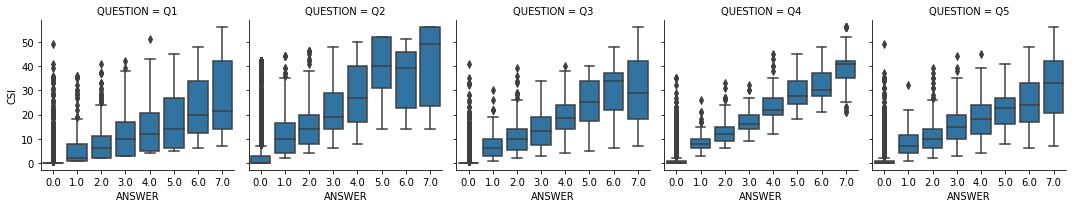

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


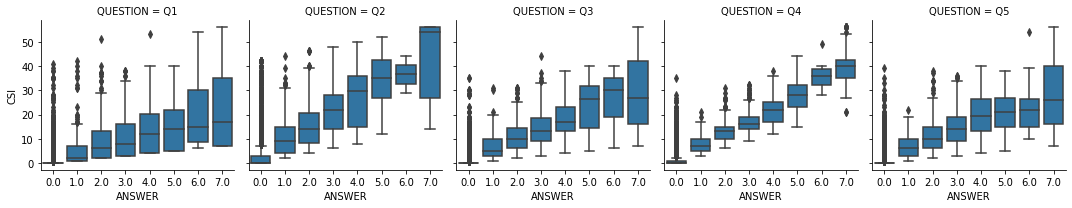

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


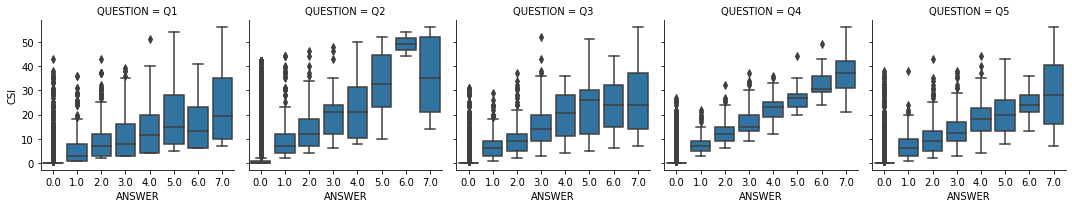

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


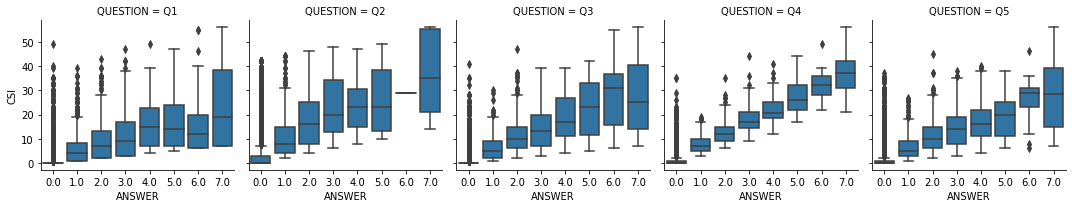

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


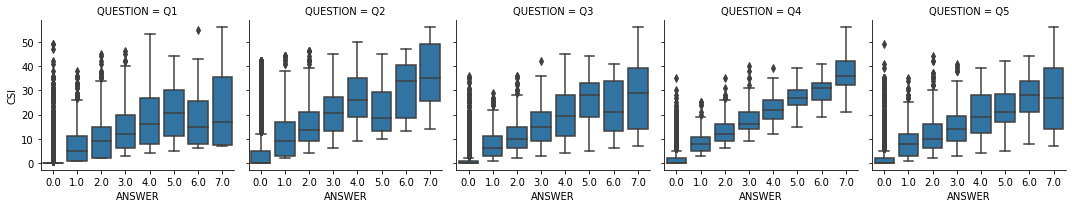

In [95]:
for k in dfs:
    df = dfs[k]
    plot_question_csi(df)

# CONCAT EVERY DATA FILE
Some functions we'll use to concat those files, we then add a column refering to the year of the file.

In [96]:
dfs_list = [dfs[2014], dfs[2015], dfs[2016], dfs[2017], dfs[2018]]
raw_data = concat(dfs_list)

# SAVES ALL DATA CONCATENED IN A CSV FILE
raw_data.to_csv(path + 'donnees.csv')

raw_data = raw_data[raw_data.CSI != 0.0]
raw_data

,REG,PROV,COM,VIL,MEN,YEAR,Q1,Q2,Q3,Q4,Q5,CSI
20,1,13,1,21,26,2014,0.0,1.0,0.0,0.0,0.0,2.0
21,1,13,1,21,45,2014,0.0,0.0,0.0,1.0,5.0,8.0
22,1,13,1,21,57,2014,0.0,0.0,2.0,0.0,0.0,2.0
27,1,13,1,25,181,2014,0.0,0.0,3.0,0.0,3.0,6.0
31,1,13,1,28,37,2014,1.0,0.0,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25980,13,41,5,14,39,2018,2.0,0.0,1.0,1.0,1.0,7.0
25981,13,41,5,14,43,2018,2.0,0.0,1.0,1.0,1.0,7.0
25982,13,41,5,14,53,2018,1.0,0.0,0.0,1.0,0.0,4.0
25983,13,41,5,14,68,2018,2.0,0.0,2.0,1.0,0.0,7.0


In [97]:
print("NB DE COM : {}".format(raw_data.COM.unique().shape[0]))
print("NB DE PROV : {}".format(raw_data.PROV.unique().shape[0]))
print("NB DE REG : {}".format(raw_data.REG.unique().shape[0]))

print(raw_data[col["data"] + col["target"]].describe().to_markdown())

NB DE COM : 16
NB DE PROV : 45
NB DE REG : 13
|       |          Q1 |           Q2 |          Q3 |          Q4 |          Q5 |        CSI |
|:------|------------:|-------------:|------------:|------------:|------------:|-----------:|
| count | 10606       | 10608        | 10606       | 10598       | 10598       | 10625      |
| mean  |     2.29842 |     0.515083 |     1.94805 |     1.40649 |     1.78949 |    11.2611 |
| std   |     2.20963 |     1.20429  |     2.34458 |     2.12795 |     2.38981 |    10.9788 |
| min   |     0       |     0        |     0       |     0       |     0       |     1      |
| 25%   |     0       |     0        |     0       |     0       |     0       |     3      |
| 50%   |     2       |     0        |     1       |     0       |     1       |     7      |
| 75%   |     3       |     0        |     3       |     2       |     3       |    15      |
| max   |     7       |     7        |     7       |     7       |     7       |    56      |


In [98]:
plot_data = raw_data.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")
plot_data.YEAR.unique()

array([2014, 2015, 2016, 2017, 2018])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


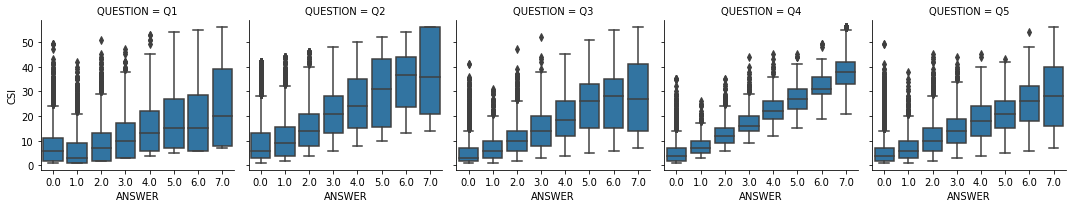

In [110]:
g = sns.FacetGrid(plot_data, col="QUESTION")
g.map(sns.boxplot, "ANSWER", "CSI")
plt.show()

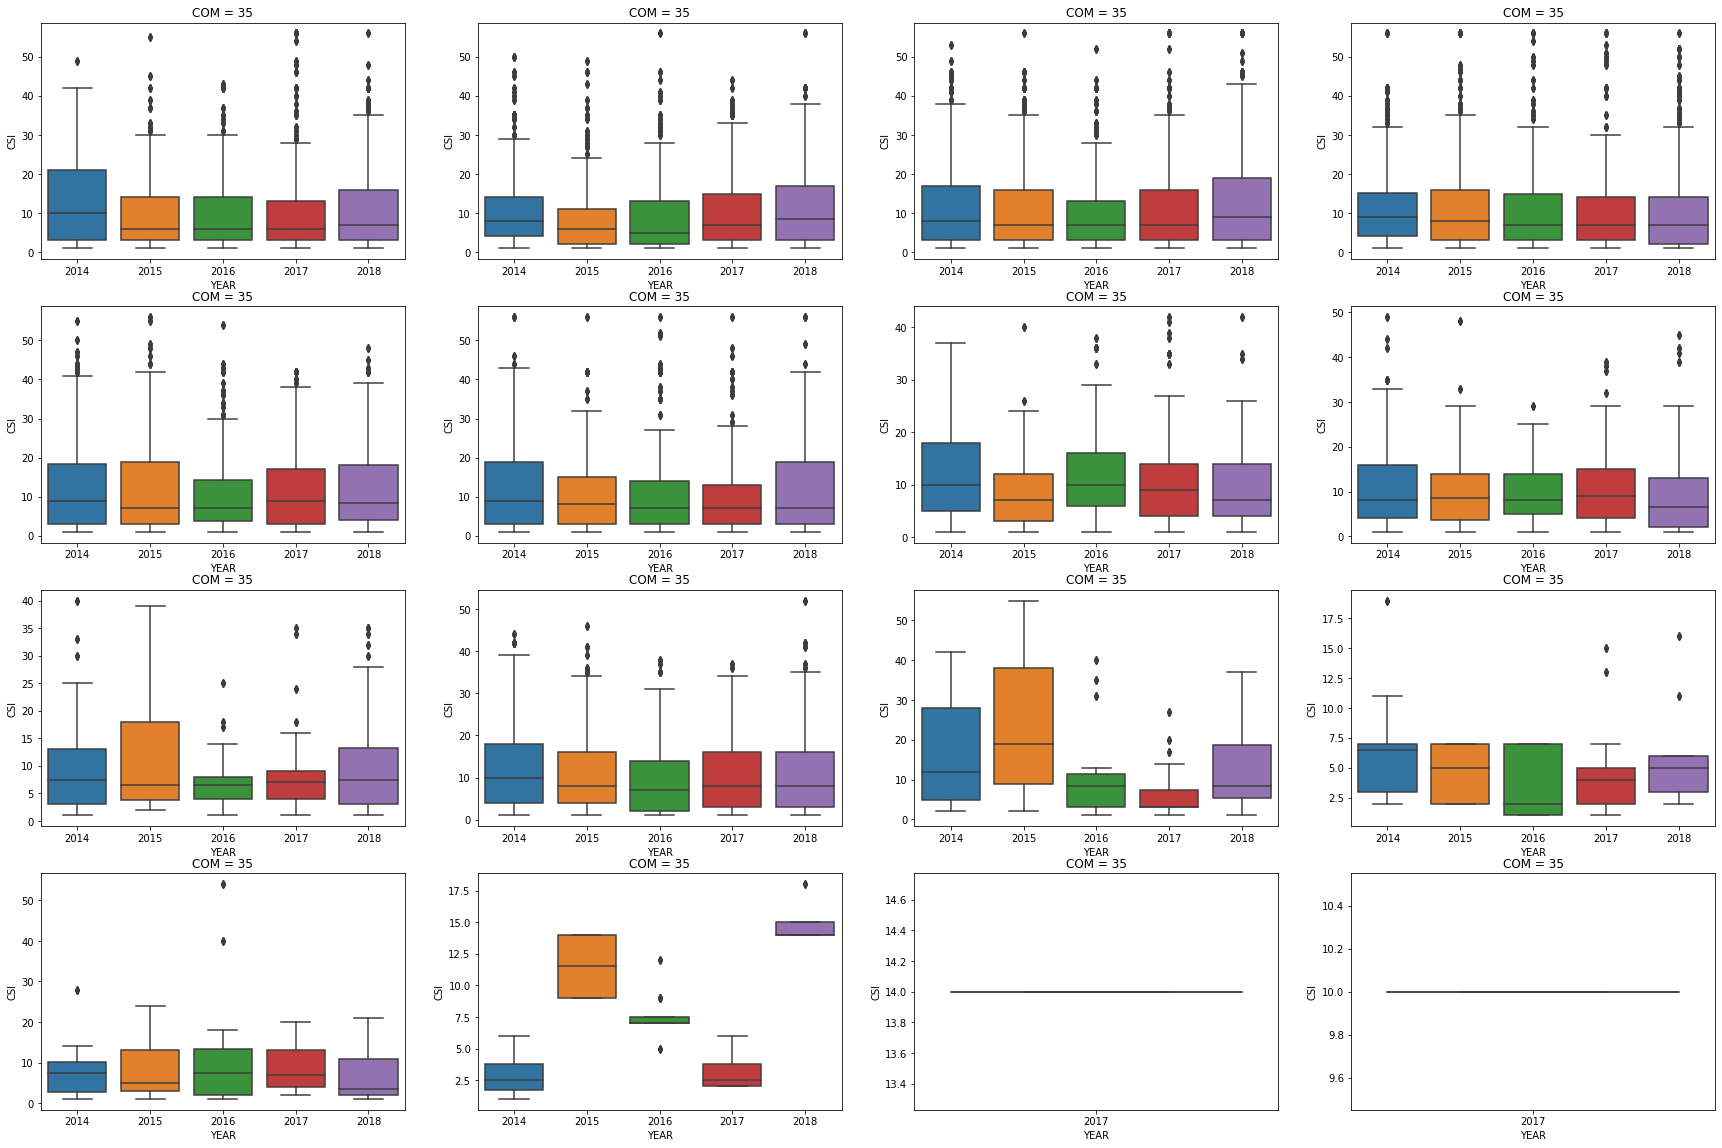

In [119]:
geo_col = "COM"
plt.figure(figsize=(30,20))
for i, geo in enumerate(plot_data[geo_col].unique()):
    df = plot_data[plot_data[geo_col] == geo]

    data = []
    for j, year in enumerate(plot_data.YEAR.unique()):
        data.append(df[df.YEAR == year].CSI)

    plt.subplot(4, 4, i+1)
    plt.title(geo_col + " = " + str(com).upper())
    sns.boxplot(x=df.YEAR, y=df.CSI)

In [ ]:
# g = sns.FacetGrid(plot_data, col="COM", col_wrap=4)
# g.map(sns.boxplot, "ANSWER", "CSI")# hue="YEAR")
# plt.show()

In [120]:
# data_clean = pd.DataFrame()

# data_clean[col["metadata"]] = raw_data[col["metadata"]]
# data_clean[col["target"]] = raw_data[col["target"]]

# data_clean[""]
# for c in col["data"]:
#     mask = (raw_data[c] == 0)
#     data_clean[c] = raw_data[mask]

# ANALYSE

Certaines colonnes ont des noms différents et représentant la même métrique, d'autres ne nous intéresse tout simplement pas.
On veut alors essayer de réduire le nombre de colonnes.

__D'abord quelques infos à propos du jeu de données__

In [ ]:
# print("Total rows : {}\n".format(raw_data.shape[0]))

# print("Number of rows containing a NaN value in each columns\n{}".format(raw_data.isna().sum()))

# print("\nNumbers of rows by year")
# for (year) in (raw_data.YEAR.unique()):
#     print("\t {} : {}".format(year, raw_data[raw_data.YEAR == year].shape[0]))

Let's see if there is the same amount of data over the years :

In [ ]:
# for year in raw_data.YEAR.unique():
#     print("YEAR {}/{} :".format(year[:4], year[4:]))
#     print("\tNumber of missing CSI rows : {}/{}".format(raw_data[raw_data.YEAR == year].CSI.isna().sum(),
#                                                         raw_data[raw_data.YEAR == year].shape[0]))
#     print("\tNumber of REG : {}".format(raw_data[raw_data.YEAR == year].loc[:, "REG"].unique().shape[0]))
#     print("\tNumber of PROV : {}".format(raw_data[raw_data.YEAR == year].loc[:, "PROV"].unique().shape[0]))
#     print("\tNumber of COM : {}".format(raw_data[raw_data.YEAR == year].loc[:, "COM"].unique().shape[0]))
#     print("\tNumber of VIL : {}".format(raw_data[raw_data.YEAR == year].loc[:, "VIL"].unique().shape[0]))
    

__Now let's focus on columns that we're interested in :__

In [ ]:
# for col in raw_data.columns:
#     print(col)

In [ ]:
# All those columns, are answers to different questions ask to compute a CSI score.
# don't know the difference between S62 and S63,
# some rows answer only to S62 questions, some answers to all S62 and S63 questions

S62_Q1 = ["S62Q1_1","S62Q1_2","S62Q1_3","S62Q1_4","S62Q1_5"]
S62_Q2 = ["S62Q21_1","S62Q21_2","S62Q22_1","S62Q22_2","S62Q23_1","S62Q23_2","S62Q24_1","S62Q24_2","S62Q25_1","S62Q25_2","S62Q26_1","S62Q26_2","S62Q27_1","S62Q27_2","S62Q28_1","S62Q28_2","S62Q29_1","S62Q29_2","S62Q210_1","S62Q210_2"]
S62_Q3 = ["S62Q3"]
S62_Q4 = ["S62Q4_1","S62Q5_1","S62Q4_2","S62Q5_2","S62Q4_3"]
S62_Q5 = ["S62Q5_3","S62Q2","S62Q3_1","S62Q3_2","S62Q3_3"]
S62_COR_DEF = ["S62Q2_c","S62Q4_3_cor1","S62Q2_1","S62Q3_cor","S62Q4_1_cor","S62Q4_1_def","S62Q4_2_cor","S62Q4_2_def","S62Q4_3_cor","S62Q4_3_def","S62Q5_1_cor","S62Q5_1_def","S62Q5_2_cor","S62Q5_2_def","S62Q5_3_cor","S62Q5_3_def", "S62Q24_1_COR","S62Q4_1_COR"]
S62 = S62_Q1 + S62_Q2 + S62_Q3 + S62_Q4 + S62_Q5 #+ S62_COR_DEF

S63_Q1 = ["S63Q1_A","S63Q1_B","S63Q1_C","S63Q1_D","S63Q1_E","S63Q1_F","S63Q1_G","S63Q1_H","S63Q1_I","S63Q1_J","S63Q1_K","S63Q1_L","S63Q1_M"]
S63_Q2 = ["S63Q2_A","S63Q2_B","S63Q2_C","S63Q2_D"]
S63_Q3 = ["S63Q3_A","S63Q3_B","S63Q3_C","S63Q3_D","S63Q3_E","S63Q3_F","S63Q3_G","S63Q3_H","S63Q3_I","S63Q3_J","S63Q3_K"]
S63 = S63_Q1 + S63_Q2 + S63_Q3

STRATEGIE = ["Stratégie1","Stratégie2","Stratégie3","Stratégie4","Stratégie5"]

# "CSI","YEAR" : those are also useful,
# the CSI column will surely be our target column, while S63 and S62 arrays will be our variables
# "REG", "PROV", "COM", "VIL" could also be considered, but not so sure about that yet

COL_TO_KEEP = ["REG", "COM", "PROV", "VIL", "MEN", "YEAR"]
COL_TO_KEEP += S62_Q1


__Some info about the S62 and S63 columns and some other columns__

We'll add some plots when we'll know what does the columns represent

In [ ]:
# Number of NaN values in each column of S62 type
# raw_data.loc[:, S62].isna().sum()

In [ ]:
# Number of NaN values in each column of S63 type
# raw_data.loc[:, S63].isna().sum()

In [121]:
# Number of NaN values in CSI column
raw_data.loc[:, "CSI"].isna().sum()

0

You can notice that half the data is not mesured, some rows could be filled by calculating the CSI with the help of all S62 and S63 columns. 

# FEATURE ENGINEERING
----
We'll see if there is any transformation needed in the data, we could also complete some rows by computing the CSI score.

# MODELING